In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, max_error, mean_absolute_error, median_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from itertools import product
import sys  
sys.path.insert(0, '/content/drive/MyDrive/ML/Project 2/')
from preprocessing import *
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# Preprocessing

In [3]:
ion_concentration = read_ion_concentration_csv()
ion_concentration.head(2)

,date,Na,Mg,K,Ca,Cl,NO3,SO4,Na_MS,Mg_MS,K_MS,Ca_MS,comments_IC,comments_MS
0,2017-03-06 17:20:00,3.232,4.209,NaN,64.711,NaN,1.751,17.637,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-03-06 18:20:00,3.268,4.241,1.112,64.043,0.559,1.771,17.740,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
ion_concentration.shape

(19095, 14)

In [5]:
#does all the preprocessing on ion_concentration
prepare_ion_concentration_dataframe(ion_concentration)
ion_concentration = ion_concentration.drop('count_nan', axis=1)
ion_concentration.head(2)

,Na,Mg,K,Ca,Cl,NO3,SO4,Na_MS,Mg_MS,K_MS,Ca_MS,comments_IC,comments_MS
date,,,,,,,,,,,,,
2017-03-06 17:20:00,3.232,4.209,NaN,64.711,NaN,1.751,17.637,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-06 18:20:00,3.268,4.241,1.112,64.043,0.559,1.771,17.740,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
ion_concentration.shape

(19050, 13)

In [7]:
probe_data10min = read_probe_data10min_csv()
probe_data10min.head(2)

,date,precipitation,water_temperature,water_electrical_conductivity,flow,comments_WSLdata,turbidity,NO3-Neq,TOCeq,DOCeq,dissolved_oxygen,temperature_DO,conductivity,temperature_EC,pH,ORP,comments_SCANdata,dQ/dt
0,2016-08-30 00:00:00,0.0,14.2,259.0,0.007371,NaN,5.78,1.5,5.59,3.54,7.74,16.8,262.0,15.9,8.17,368.0,NaN,0.000171
1,2016-08-30 00:10:00,0.0,14.0,259.8,0.007200,NaN,5.57,1.5,5.56,3.53,7.75,16.8,262.0,15.9,8.16,368.0,NaN,-0.000171


In [8]:
probe_data10min.shape

(210086, 18)

In [9]:
#does all the preprocessing on probe_data10min
prepare_probe_data10min_dataframe(probe_data10min)
probe_data10min = probe_data10min.drop('count_nan', axis=1)
probe_data10min.head(2)

,precipitation,water_temperature,water_electrical_conductivity,flow,comments_WSLdata,turbidity,NO3-Neq,TOCeq,DOCeq,dissolved_oxygen,temperature_DO,conductivity,temperature_EC,pH,ORP,comments_SCANdata,dQ/dt,time_of_day,time_of_year
date,,,,,,,,,,,,,,,,,,,
2016-08-30 00:00:00,0.0,1.181844,259.0,2.260273,NaN,0.831230,1.5,0.818885,3.54,7.74,16.8,262.0,15.9,8.17,368.0,NaN,0.000171,-8.899440e-12,-0.851486
2016-08-30 00:10:00,0.0,1.176091,259.8,2.249741,NaN,0.817565,1.5,0.816904,3.53,7.75,16.8,262.0,15.9,8.16,368.0,NaN,-0.000171,4.361939e-02,-0.851549


In [10]:
probe_data10min.shape

(210085, 19)

# Boosting Regressor

## Calcium

Merge the 2 dataframes on the date. We will train our model on features and outputs present in both tables (same time). Only take the values for which the Ca concentration is available.

In [15]:
calcium = ion_concentration[ion_concentration['Ca'].notna()].Ca.to_frame()
#drop non features columns
probe_data10min_no_comments = probe_data10min.drop(['comments_WSLdata', 'comments_SCANdata'], axis=1)
calcium_and_features = pd.merge(probe_data10min_no_comments, calcium, left_index=True, right_index=True)
calcium_and_features.head(2)

,precipitation,water_temperature,water_electrical_conductivity,flow,turbidity,NO3-Neq,TOCeq,DOCeq,dissolved_oxygen,temperature_DO,conductivity,temperature_EC,pH,ORP,dQ/dt,time_of_day,time_of_year,Ca
date,,,,,,,,,,,,,,,,,,
2017-03-06 17:20:00,0.0,0.204120,208.0,2.512760,0.955688,1.11,0.797268,3.61,9.71,5.1,210.0,4.2,8.03,371.0,-0.000771,-0.984808,0.901735,64.711
2017-03-06 18:20:00,0.0,0.255273,206.5,2.503481,1.024896,1.10,0.808211,3.90,9.84,5.5,208.0,4.5,8.00,375.0,0.000000,-0.996195,0.902045,64.043


In [ ]:
calcium_and_features.shape

(14221, 18)

###Model training and testing

In [33]:
Ca_related_features = calcium_and_features.columns[0:len(calcium_and_features.columns)-1]
Ca_related_features

Index(['precipitation', 'water_temperature', 'water_electrical_conductivity',
       'flow', 'turbidity', 'NO3-Neq', 'TOCeq', 'DOCeq', 'dissolved_oxygen',
       'temperature_DO', 'conductivity', 'temperature_EC', 'pH', 'ORP',
       'dQ/dt', 'time_of_day', 'time_of_year'],
      dtype='object')

In [34]:
y = calcium_and_features['Ca']
X = calcium_and_features[Ca_related_features]

In [35]:
#fill NaN values with the median of the respective column/feature
X = X.fillna(X.median())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
print('Length of the train dataset: {}'.format(len(X_train)))
print('Length of the test dataset: {}'.format(len(X_test)))

#save the dates of y_test
y_test_index = y_test.index

#transform to numpy
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

Length of the train dataset: 9954
Length of the test dataset: 4267


We will divide our **training** data into  𝑁  folds and perform cross-validation. We will experiment tuning two hyperparameters of the Gradient Boosting Regressor: `n_estimators` and `learning_rate`. For each possible combination of the two hyperparameters (see below for the range of values that we will try for each hyperparameter), we will train our model in a cross-validation setup with  𝑁=10  folds. We will report the mean RMSE.

- `n_estimators`  ∈{125, 250, 500, 1000} 
- `learning_rate`  ∈{1, 0.5, 0.25, 0.1, 0.05} .

With the best hyperparameters obtained, we will train our model with the **entire** training set and report the RMSE  on the testing set (not touched until this step).

In [36]:
def gradient_boosting_cv(X, y, N, n_estimators, learning_rate, verbose=False):
  """
  Performs N-fold cross validation on gradient boosting regressor, given two hyperparameters.
  Returns RMSEs
  """
  kf = KFold(n_splits=N)
  regr = GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=n_estimators)
  RMSEs = np.zeros(N)
  i = 0
  if verbose:
    print('\nGradient Boosting regressor hyperparameters:\nnb of estimators = {:d}, learning rate = {:.2f}'\
    .format(n_estimators, learning_rate))

  for train_index, test_index in kf.split(X):
    #obtain train and testing sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regr.fit(X_train, y_train)
    #predict
    y_predicted = regr.predict(X_test)
    #add corresponding RMSE to the list of RMSEs

    
    RMSEs[i] = mean_squared_error(y_test, y_predicted, squared=False)
    i += 1

    if verbose:
      print("Fold {:d} out of {:d} completed".format(i, N))
  
  #compute mean of RMSEs
  mean_RMSE = RMSEs.mean()

  if verbose: 
    print("RMSE is {:.2f}".format(mean_RMSE))

  return mean_RMSE

In [37]:
n_estimators_array = np.array([125, 250, 500, 1000])
learning_rate_array = np.array([1, 0.5, 0.25, 0.1, 0.05])

N = 10

# get all combinations of hyperparameters
hyperparams = list(product(n_estimators_array, learning_rate_array))
nb_combinations = len(hyperparams)
mean_RMSEs = np.zeros(nb_combinations)

i = 0
for n_estimators, learning_rate in hyperparams:
  mean_RMSEs[i] = gradient_boosting_cv(X_train, y_train, N, n_estimators, learning_rate, verbose=False)
  i += 1

In [38]:
#the best hyperparameters correspond to the minimal mean RMSE
best_mean_RMSE = mean_RMSEs.argmin()
#extract best hyperparameters
best_n_estimators = hyperparams[best_mean_RMSE][0]
best_learning_rate = hyperparams[best_mean_RMSE][1]
print('The best model is obtained with n_estimators = {:d} and learning rate = {:.2f}' \
      .format(best_n_estimators, best_learning_rate))

The best model is obtained with n_estimators = 1000 and learning rate = 0.25


In [39]:
# Create Gradient Boosting Regressor with best hyperparameters
regr = GradientBoostingRegressor(learning_rate=best_learning_rate, n_estimators=best_n_estimators)

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions on the testing set
y_predicted = regr.predict(X_test)

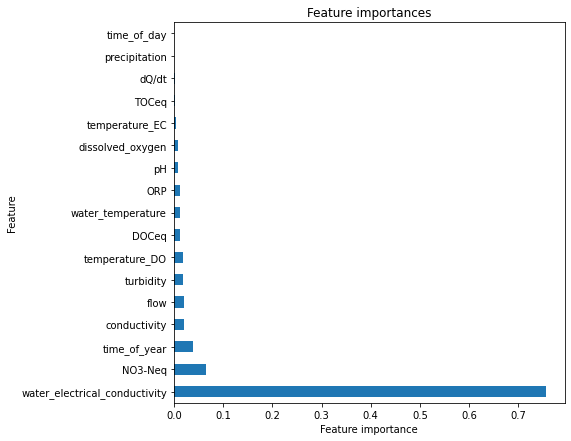

In [40]:
#plot graph of feature importances for better visualization
plt.figure(figsize=(7,7))
feat_importances = pd.Series(regr.feature_importances_, index=calcium_and_features[Ca_related_features].columns)
feat_importances.nlargest(len(Ca_related_features)).plot(kind='barh')
plt.title('Feature importances')
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.savefig("/content/drive/MyDrive/ADA/Saved data/feature_importances_Ca.png", bbox_inches='tight', dpi=300)
plt.show()

In [41]:
#RMSE: 0 is perfect prediction
print("The RMSE for the best model trained on all the training set, over the testing set, is: %.3f" 
       % mean_squared_error(y_test, y_predicted, squared=False))

# The coefficient of determination: 1 is perfect prediction
print("The coefficient of determination for the best model trained on all the training set, over the testing set, is: %.3f"
     % r2_score(y_test, y_predicted))

print("The maximum error is: %.3f mg/l" % max_error(y_test, y_predicted))

#Mean absolute error regression loss
print("The mean absolute error is: %.3f mg/l" % mean_absolute_error(y_test, y_predicted))

#Median absolute error regression loss
print("The median absolute error is: %.3f mg/l" % median_absolute_error(y_test, y_predicted))

The RMSE for the best model trained on all the training set, over the testing set, is: 1.518
The coefficient of determination for the best model trained on all the training set, over the testing set, is: 0.976
The maximum error is: 21.294 mg/l
The mean absolute error is: 0.921 mg/l
The median absolute error is: 0.553 mg/l


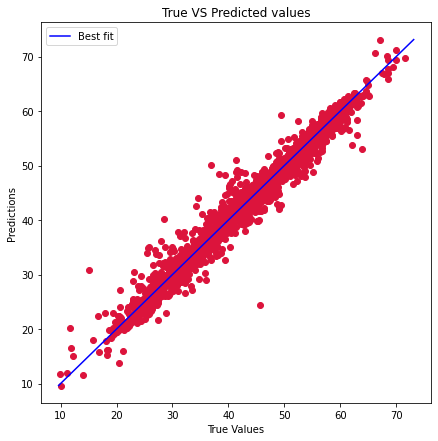

In [42]:
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_predicted, c='crimson')
plt.title('True VS Predicted values')

p1 = max(max(y_predicted), max(y_test))
p2 = min(min(y_predicted), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-', label='Best fit')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.legend()
plt.savefig("/content/drive/MyDrive/ADA/Saved data/true_and_predicted.png", bbox_inches='tight', dpi=300)
plt.show()

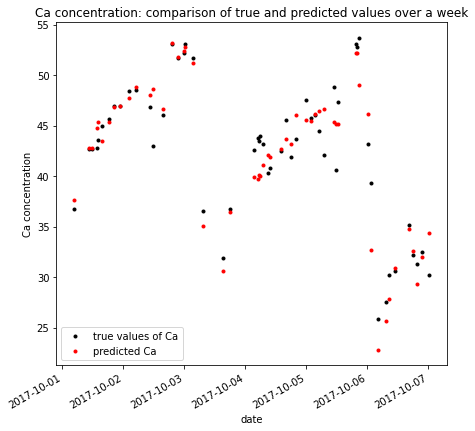

In [43]:
y_predicted = pd.DataFrame(y_predicted, columns=['predicted_Ca']).set_index(y_test_index)
y_true = pd.DataFrame(y_test, columns=['true_values']).set_index(y_test_index)

#dataframe with already available and predicted values
true_and_predicted = pd.concat([y_true, y_predicted])
#sort the datetime index
true_and_predicted = true_and_predicted.sort_index()
true_and_predicted.head()

start_date = "2017-10-01"
end_date = "2017-10-07"

plt.figure(figsize=(7,7))

true_and_predicted[start_date : end_date ]['true_values'].plot(style='k.', label='true values of Ca')
true_and_predicted[start_date : end_date ]['predicted_Ca'].plot(style='r.', label='predicted Ca')
plt.ylabel('Ca concentration')
plt.title('Ca concentration: comparison of true and predicted values over a week')
plt.legend()
plt.savefig("/content/drive/MyDrive/ADA/Saved data/true_predicted_week.png", bbox_inches='tight', dpi=300)
plt.show()

As we need to do the same steps as above for other ion concentrations, we create a single function in order to avoid copy pasting code.

In [44]:
def model_train_and_test(ion_and_features, ion, ion_related_features):
  y = ion_and_features[ion]
  X = ion_and_features[ion_related_features]

  #fill NaN values with the median of the respective column/feature
  X = X.fillna(X.median())  

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
  print('Length of the train dataset: {}'.format(len(X_train)))
  print('Length of the test dataset: {}'.format(len(X_test)))

  #save the dates of y_test
  y_test_index = y_test.index

  #transform to numpy
  X_train = X_train.to_numpy()
  X_test = X_test.to_numpy()
  y_train = y_train.to_numpy()
  y_test = y_test.to_numpy()

  #Cross validation
  n_estimators_array = np.array([125, 250, 500, 1000])
  learning_rate_array = np.array([1, 0.5, 0.25, 0.1, 0.05])

  N = 10

  # get all combinations of hyperparameters
  hyperparams = list(product(n_estimators_array, learning_rate_array))
  nb_combinations = len(hyperparams)
  mean_RMSEs = np.zeros(nb_combinations)

  i = 0
  for n_estimators, learning_rate in hyperparams:
    mean_RMSEs[i] = gradient_boosting_cv(X_train, y_train, N, n_estimators, learning_rate, verbose=False)
    i += 1

  #the best hyperparameters correspond to the minimal mean RMSE
  best_mean_RMSE = mean_RMSEs.argmin()
  #extract best hyperparameters
  best_n_estimators = hyperparams[best_mean_RMSE][0]
  best_learning_rate = hyperparams[best_mean_RMSE][1]
  print('The best model is obtained with n_estimators = {:d} and learning rate = {:.2f}' \
      .format(best_n_estimators, best_learning_rate))

  # Create Gradient Boosting Regressor with best hyperparameters
  regr = GradientBoostingRegressor(learning_rate=best_learning_rate, n_estimators=best_n_estimators)

  # Train the model using the training sets
  regr.fit(X_train, y_train)

  # Make predictions on the testing set
  y_predicted = regr.predict(X_test)

  #plot graph of feature importances for better visualization
  plt.figure(figsize=(7,7))
  feat_importances = pd.Series(regr.feature_importances_, index=ion_and_features[ion_related_features].columns)
  feat_importances.nlargest(len(ion_related_features)).plot(kind='barh')
  plt.title('Feature importances')
  plt.xlabel('Feature importance')
  plt.ylabel('Feature')
  plt.savefig("/content/drive/MyDrive/ADA/Saved data/feature_importances_" + ion +'.png', bbox_inches='tight', dpi=300)
  plt.show()

  #RMSE: 0 is perfect prediction
  print("The RMSE for the best model trained on all the training set, over the testing set, is: %.3f" 
        % mean_squared_error(y_test, y_predicted, squared=False))

  # The coefficient of determination: 1 is perfect prediction
  print("The coefficient of determination for the best model trained on all the training set, over the testing set, is: %.3f"
        % r2_score(y_test, y_predicted))

  print("The maximum error is: %.3f mg/l" % max_error(y_test, y_predicted))

  #Mean absolute error regression loss
  print("The mean absolute error is: %.3f mg/l" % mean_absolute_error(y_test, y_predicted))

  #Median absolute error regression loss
  print("The median absolute error is: %.3f mg/l" % median_absolute_error(y_test, y_predicted))

  plt.figure(figsize=(7,7))
  plt.scatter(y_test, y_predicted, c='crimson')
  plt.title('True VS Predicted values')
  p1 = max(max(y_predicted), max(y_test))
  p2 = min(min(y_predicted), min(y_test))
  plt.plot([p1, p2], [p1, p2], 'b-', label='Best fit')
  plt.xlabel('True Values')
  plt.ylabel('Predictions')
  plt.legend()
  plt.savefig("/content/drive/MyDrive/ADA/Saved data/true_and_predicted" + ion + '.png', bbox_inches='tight', dpi=300)
  plt.show()


  y_predicted = pd.DataFrame(y_predicted, columns=['predicted_' + ion]).set_index(y_test_index)
  y_true = pd.DataFrame(y_test, columns=['true_values']).set_index(y_test_index)

  #dataframe with already available and predicted values
  true_and_predicted = pd.concat([y_true, y_predicted])
  #sort the datetime index
  true_and_predicted = true_and_predicted.sort_index()
  true_and_predicted.head()

  start_date = "2017-10-01"
  end_date = "2017-10-07"

  plt.figure(figsize=(7,7))

  true_and_predicted[start_date : end_date ]['true_values'].plot(style='k.', label='true values of ' + ion)
  true_and_predicted[start_date : end_date ]['predicted_' + ion].plot(style='r.', label='predicted ' + ion)
  plt.ylabel(ion + ' concentration')
  plt.title(ion + ' concentration: comparison of true and predicted values over a week')
  plt.legend()
  plt.savefig("/content/drive/MyDrive/ADA/Saved data/true_predicted_week" + ion + '.png', bbox_inches='tight', dpi=300)
  plt.show()

  return regr

### Predicting

Now that we have a trained model, we can use it to predict the values of the Calcium using the features from the second dataset. 

We have only used a part of the probe data (for training and testing), namely the measure at a given moment when a Calcium concentration (label) was also available. We will now use the rest of the probe data in order to make predictions.

We will need all the probe data that we didn't use for training and testing, therefore the data that is in `probe_data10min` and not in `calcium_and_features`.

In [45]:
features_for_prediction = pd.concat([probe_data10min[Ca_related_features], 
                                     calcium_and_features[Ca_related_features]]).drop_duplicates(keep=False)
#number of values to predict
features_for_prediction.shape                        

(195885, 17)

In [46]:
#fill NaN values with the median of the respective column/feature
features_for_prediction = features_for_prediction.fillna(features_for_prediction.median())
#check that there aren't NaN values
np.count_nonzero(np.isnan(features_for_prediction))

0

In [47]:
X_prediction = features_for_prediction.to_numpy()

y_predicted = regr.predict(X_prediction)
y_predicted = pd.DataFrame(y_predicted, columns=['predicted_Ca']).set_index(features_for_prediction.index)
y_predicted.head()

,predicted_Ca
date,
2016-08-30 00:00:00,50.212179
2016-08-30 00:10:00,50.442104
2016-08-30 00:20:00,50.888177
2016-08-30 00:30:00,50.344081
2016-08-30 00:40:00,50.780929


In [48]:
y_available = calcium_and_features['Ca'].to_frame(name='available_Ca')
y_available.head()

,available_Ca
date,
2017-03-06 17:20:00,64.711
2017-03-06 18:20:00,64.043
2017-03-06 21:20:00,63.400
2017-03-06 22:20:00,63.785
2017-03-06 23:20:00,63.603


In [49]:
#dataframe with already available and predicted values
avaialble_and_predicted = pd.concat([y_available, y_predicted])
#sort the datetime index
avaialble_and_predicted = avaialble_and_predicted.sort_index()
avaialble_and_predicted.head()

,available_Ca,predicted_Ca
date,,
2016-08-30 00:00:00,NaN,50.212179
2016-08-30 00:10:00,NaN,50.442104
2016-08-30 00:20:00,NaN,50.888177
2016-08-30 00:30:00,NaN,50.344081
2016-08-30 00:40:00,NaN,50.780929


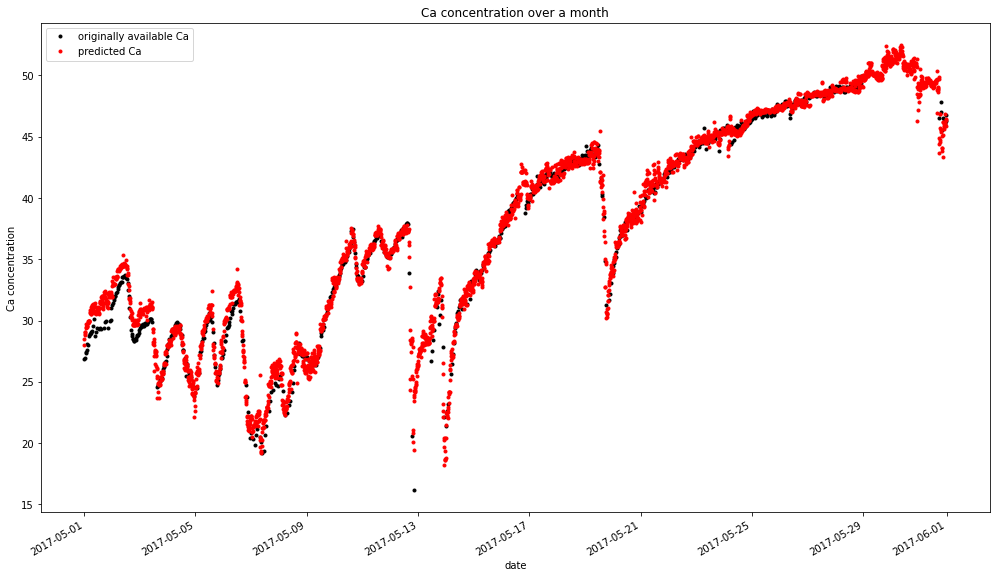

In [50]:
start_date = "2017-05"
end_date = "2017-05"

plt.figure(figsize=(17,10))

avaialble_and_predicted[start_date : end_date ]['available_Ca'].plot(style='k.', label='originally available Ca')
avaialble_and_predicted[start_date : end_date ]['predicted_Ca'].plot(style='r.', label='predicted Ca')
plt.ylabel('Ca concentration')
plt.title('Ca concentration over a month')
plt.legend()
plt.show()

We notice that the predicted values follow the patern of the originally present values, which means that the model is making predictions that are close to true values. If we zoom in, we have the following plot.

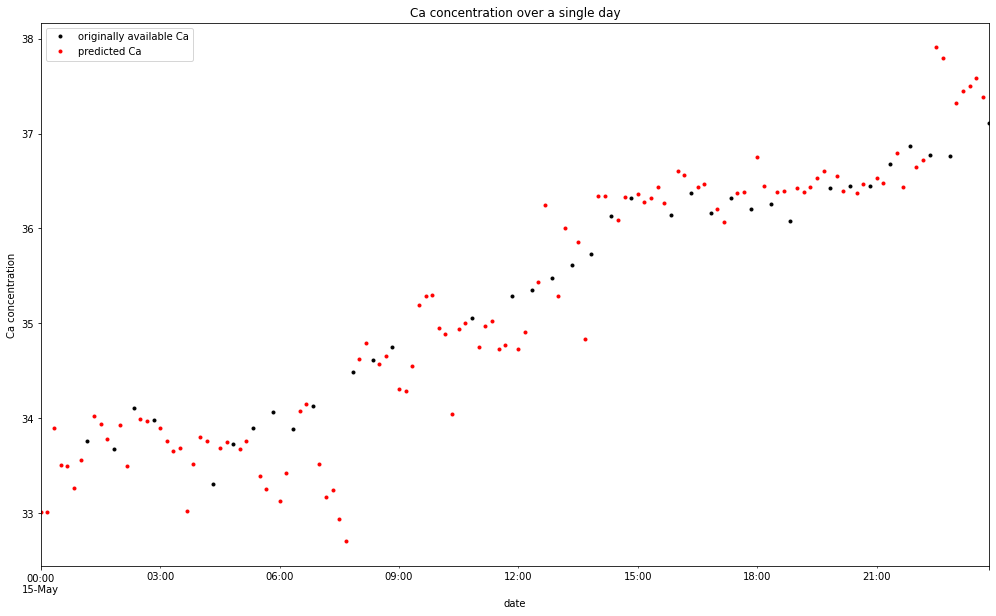

In [51]:
start_date = "2017-05-15"
end_date = "2017-05-15"

plt.figure(figsize=(17,10))

avaialble_and_predicted[start_date : end_date ]['available_Ca'].plot(style='k.', label='originally available Ca')
avaialble_and_predicted[start_date : end_date ]['predicted_Ca'].plot(style='r.', label='predicted Ca')
plt.ylabel('Ca concentration')
plt.title('Ca concentration over a single day')
plt.legend()
plt.show()

For the prediction, we also create a function that we will be able to use for the other ion concentrations.

In [13]:
def predict(ion, regr, ion_related_features, ion_and_features, start_date_1, end_date_1, start_date_2, end_date_2):
  
  features_for_prediction = pd.concat([probe_data10min[ion_related_features], 
                                     ion_and_features[ion_related_features]]).drop_duplicates(keep=False)
                      
  #fill NaN values with the median of the respective column/feature
  features_for_prediction = features_for_prediction.fillna(features_for_prediction.median())

  X_prediction = features_for_prediction.to_numpy()

  y_predicted = regr.predict(X_prediction)
  y_predicted = pd.DataFrame(y_predicted, columns=['predicted_' + ion]).set_index(features_for_prediction.index)
  y_available = ion_and_features[ion].to_frame(name='available_' + ion)

  #dataframe with already available and predicted values
  avaialble_and_predicted = pd.concat([y_available, y_predicted])
  #sort the datetime index
  avaialble_and_predicted = avaialble_and_predicted.sort_index()

  #Plot over a month
  plt.figure(figsize=(17,10))
  avaialble_and_predicted[start_date_1 : end_date_1]['available_' + ion].plot(style='k.', label='originally available ' + ion)
  avaialble_and_predicted[start_date_1 : end_date_1]['predicted_' + ion].plot(style='r.', label='predicted ' + ion)
  plt.ylabel(ion + ' concentration')
  plt.title(ion + ' concentration over a month')
  plt.legend()
  plt.show()

  #Zoom in/ plot over a day
  plt.figure(figsize=(17,10))
  avaialble_and_predicted[start_date_2 : end_date_2]['available_' + ion].plot(style='k.', label='originally available ' + ion)
  avaialble_and_predicted[start_date_2 : end_date_2]['predicted_' + ion].plot(style='r.', label='predicted ' + ion)
  plt.ylabel(ion + ' concentration')
  plt.title(ion + ' concentration over a single day')
  plt.legend()
  plt.show()

## Sulfate

In [52]:
sulfate = ion_concentration[ion_concentration['SO4'].notna()].SO4.to_frame()
sulfate_and_features = pd.merge(probe_data10min_no_comments, sulfate, left_index=True, right_index=True)
sulfate_and_features.head(2)

,precipitation,water_temperature,water_electrical_conductivity,flow,turbidity,NO3-Neq,TOCeq,DOCeq,dissolved_oxygen,temperature_DO,conductivity,temperature_EC,pH,ORP,dQ/dt,time_of_day,time_of_year,SO4
date,,,,,,,,,,,,,,,,,,
2017-03-06 17:20:00,0.0,0.204120,208.0,2.512760,0.955688,1.11,0.797268,3.61,9.71,5.1,210.0,4.2,8.03,371.0,-0.000771,-0.984808,0.901735,17.637
2017-03-06 18:20:00,0.0,0.255273,206.5,2.503481,1.024896,1.10,0.808211,3.90,9.84,5.5,208.0,4.5,8.00,375.0,0.000000,-0.996195,0.902045,17.740


In [53]:
SO4_related_features = sulfate_and_features.columns[0:len(sulfate_and_features.columns)-1]
SO4_related_features

Index(['precipitation', 'water_temperature', 'water_electrical_conductivity',
       'flow', 'turbidity', 'NO3-Neq', 'TOCeq', 'DOCeq', 'dissolved_oxygen',
       'temperature_DO', 'conductivity', 'temperature_EC', 'pH', 'ORP',
       'dQ/dt', 'time_of_day', 'time_of_year'],
      dtype='object')

In [54]:
y = sulfate_and_features['SO4']
X = sulfate_and_features[SO4_related_features]

### Model training and testing 

Length of the train dataset: 9965
Length of the test dataset: 4271
The best model is obtained with n_estimators = 1000 and learning rate = 0.10


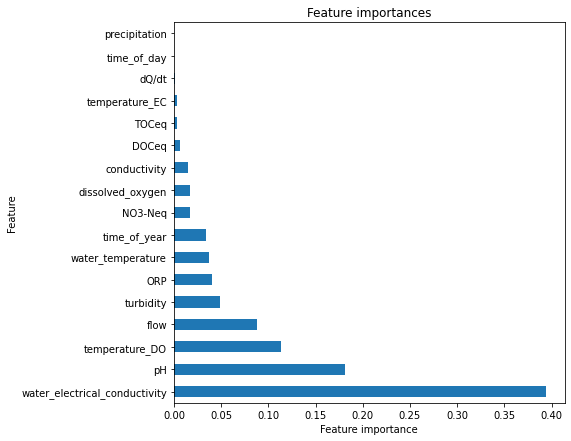

The RMSE for the best model trained on all the training set, over the testing set, is: 0.667
The coefficient of determination for the best model trained on all the training set, over the testing set, is: 0.985
The maximum error is: 8.575 mg/l
The mean absolute error is: 0.441 mg/l
The median absolute error is: 0.300 mg/l


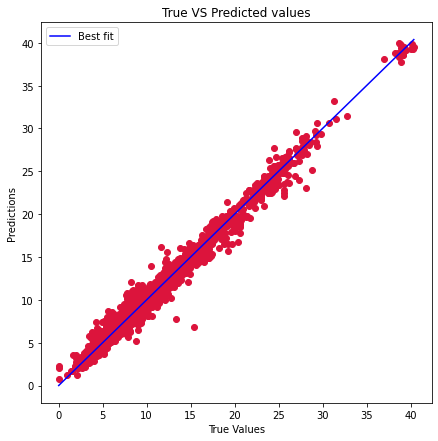

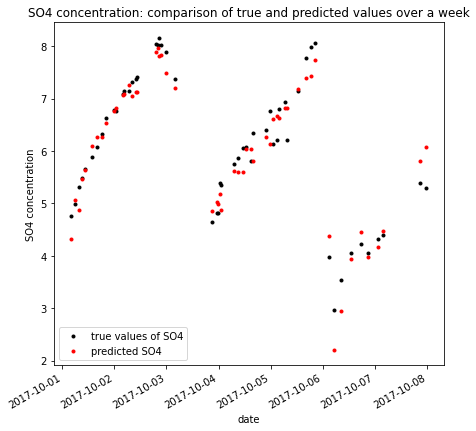

In [55]:
regr = model_train_and_test(sulfate_and_features, 'SO4', SO4_related_features)

### Predicting

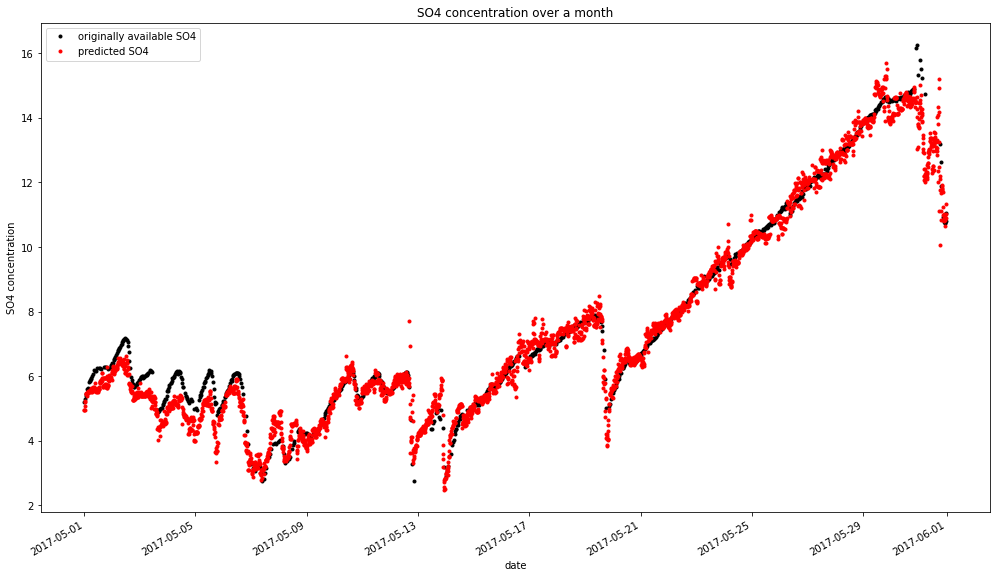

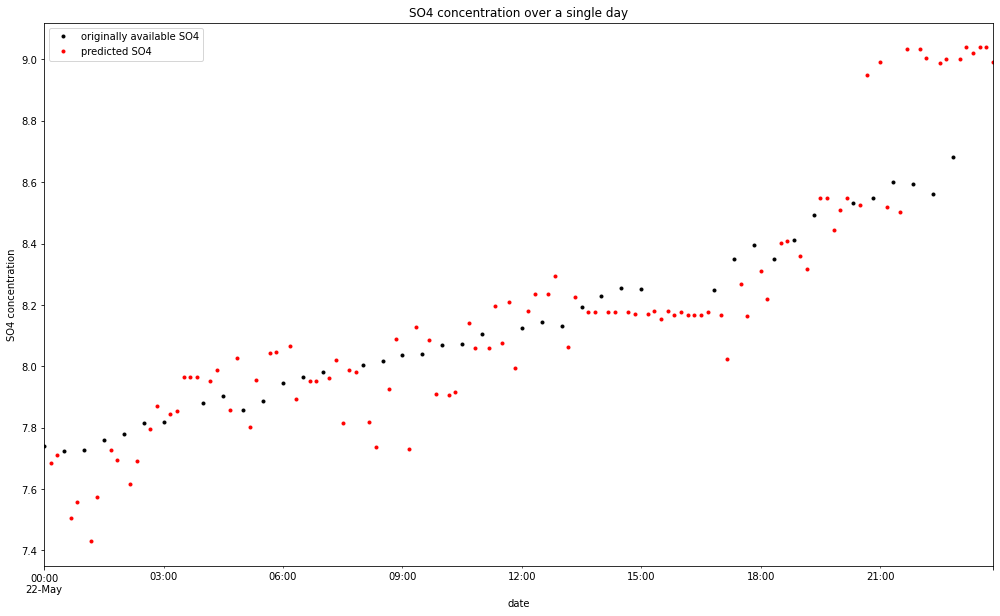

In [56]:
predict('SO4', regr, SO4_related_features, sulfate_and_features, '2017-05',  '2017-05', '2017-05-22', '2017-05-22')

## Nitrate

In [57]:
nitrate = ion_concentration[ion_concentration['NO3'].notna()].NO3.to_frame()
nitrate_and_features = pd.merge(probe_data10min_no_comments, nitrate, left_index=True, right_index=True)
nitrate_and_features.head(2)

,precipitation,water_temperature,water_electrical_conductivity,flow,turbidity,NO3-Neq,TOCeq,DOCeq,dissolved_oxygen,temperature_DO,conductivity,temperature_EC,pH,ORP,dQ/dt,time_of_day,time_of_year,NO3
date,,,,,,,,,,,,,,,,,,
2017-03-06 17:20:00,0.0,0.204120,208.0,2.512760,0.955688,1.11,0.797268,3.61,9.71,5.1,210.0,4.2,8.03,371.0,-0.000771,-0.984808,0.901735,1.751
2017-03-06 18:20:00,0.0,0.255273,206.5,2.503481,1.024896,1.10,0.808211,3.90,9.84,5.5,208.0,4.5,8.00,375.0,0.000000,-0.996195,0.902045,1.771


In [58]:
NO3_related_features = nitrate_and_features.columns[0:len(nitrate_and_features.columns)-1]
NO3_related_features

Index(['precipitation', 'water_temperature', 'water_electrical_conductivity',
       'flow', 'turbidity', 'NO3-Neq', 'TOCeq', 'DOCeq', 'dissolved_oxygen',
       'temperature_DO', 'conductivity', 'temperature_EC', 'pH', 'ORP',
       'dQ/dt', 'time_of_day', 'time_of_year'],
      dtype='object')

In [59]:
y = nitrate_and_features['NO3']
X = nitrate_and_features[NO3_related_features]

### Model training and testing

Length of the train dataset: 8855
Length of the test dataset: 3795
The best model is obtained with n_estimators = 1000 and learning rate = 0.25


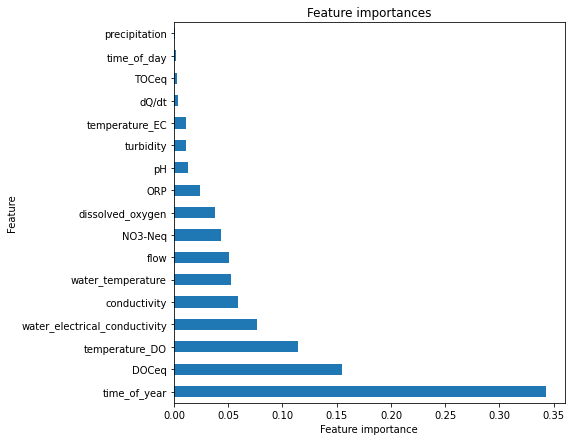

The RMSE for the best model trained on all the training set, over the testing set, is: 0.104
The coefficient of determination for the best model trained on all the training set, over the testing set, is: 0.940
The maximum error is: 1.937 mg/l
The mean absolute error is: 0.053 mg/l
The median absolute error is: 0.030 mg/l


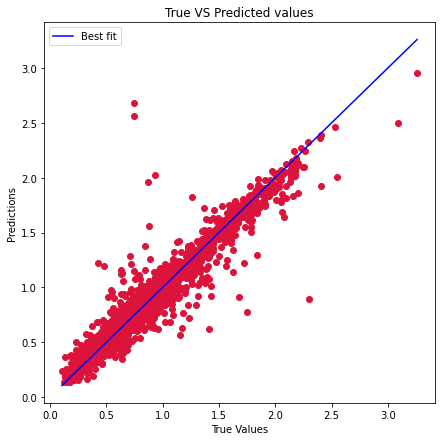

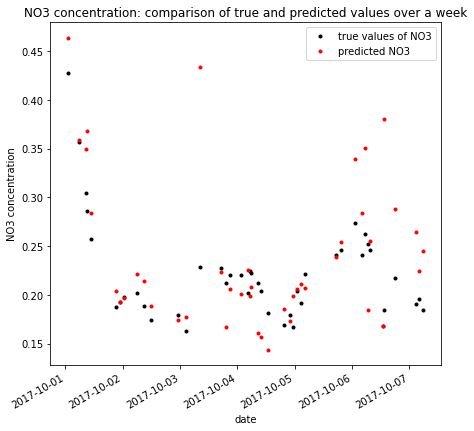

In [60]:
regr = model_train_and_test(nitrate_and_features, 'NO3', NO3_related_features)

As expected, it is more difficult to predict the concentration of NO3.

### Predicting

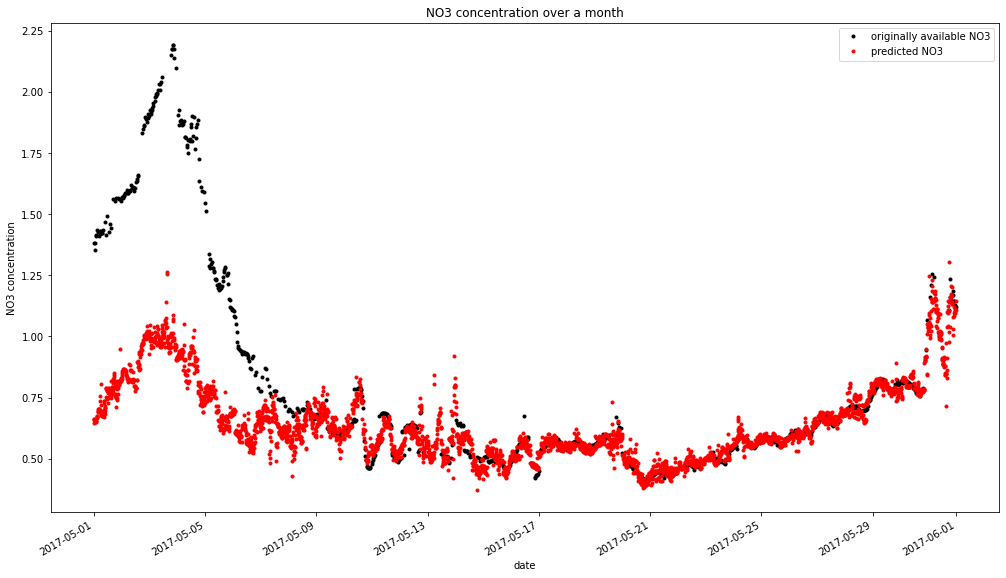

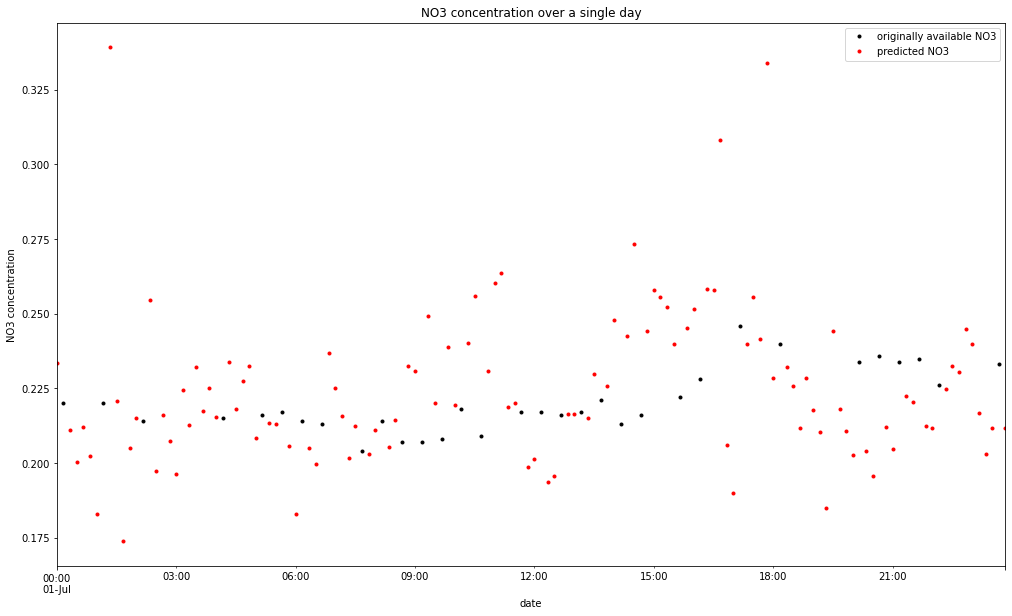

In [61]:
predict('NO3', regr, NO3_related_features, nitrate_and_features, '2017-05',  '2017-05', '2017-07-01', '2017-07-01')

## Magnesium

In [62]:
magnesium = ion_concentration[ion_concentration['Mg'].notna()].Mg.to_frame()
magnesium_and_features = pd.merge(probe_data10min_no_comments, magnesium, left_index=True, right_index=True)
magnesium_and_features.head(2)

,precipitation,water_temperature,water_electrical_conductivity,flow,turbidity,NO3-Neq,TOCeq,DOCeq,dissolved_oxygen,temperature_DO,conductivity,temperature_EC,pH,ORP,dQ/dt,time_of_day,time_of_year,Mg
date,,,,,,,,,,,,,,,,,,
2017-03-06 17:20:00,0.0,0.204120,208.0,2.512760,0.955688,1.11,0.797268,3.61,9.71,5.1,210.0,4.2,8.03,371.0,-0.000771,-0.984808,0.901735,4.209
2017-03-06 18:20:00,0.0,0.255273,206.5,2.503481,1.024896,1.10,0.808211,3.90,9.84,5.5,208.0,4.5,8.00,375.0,0.000000,-0.996195,0.902045,4.241


In [63]:
Mg_related_features = magnesium_and_features.columns[0:len(magnesium_and_features.columns)-1]
Mg_related_features

Index(['precipitation', 'water_temperature', 'water_electrical_conductivity',
       'flow', 'turbidity', 'NO3-Neq', 'TOCeq', 'DOCeq', 'dissolved_oxygen',
       'temperature_DO', 'conductivity', 'temperature_EC', 'pH', 'ORP',
       'dQ/dt', 'time_of_day', 'time_of_year'],
      dtype='object')

In [64]:
y = magnesium_and_features['Mg']
X = magnesium_and_features[Mg_related_features]

### Model training and testing

Length of the train dataset: 9040
Length of the test dataset: 3875
The best model is obtained with n_estimators = 1000 and learning rate = 0.25


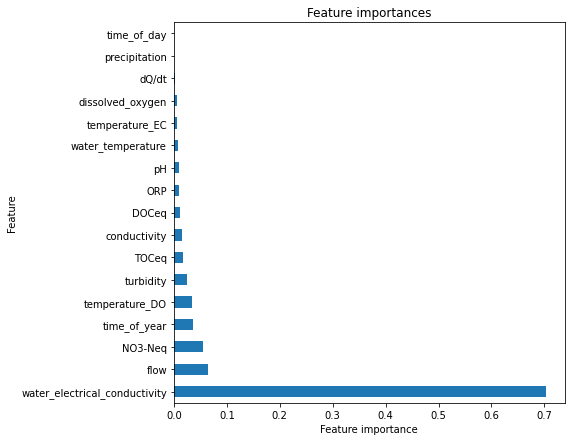

The RMSE for the best model trained on all the training set, over the testing set, is: 0.105
The coefficient of determination for the best model trained on all the training set, over the testing set, is: 0.979
The maximum error is: 1.006 mg/l
The mean absolute error is: 0.067 mg/l
The median absolute error is: 0.043 mg/l


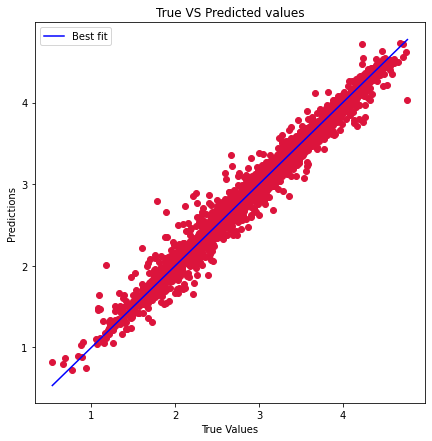

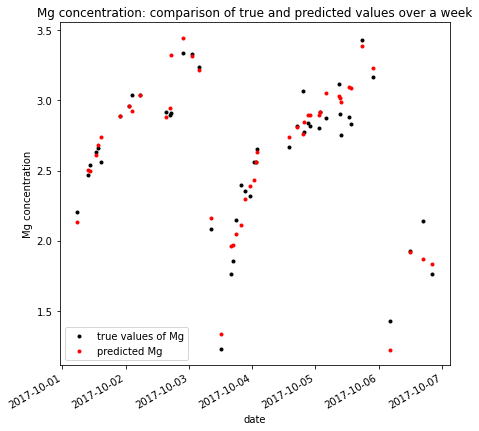

In [65]:
regr = model_train_and_test(magnesium_and_features, 'Mg', Mg_related_features)

### Predicting 

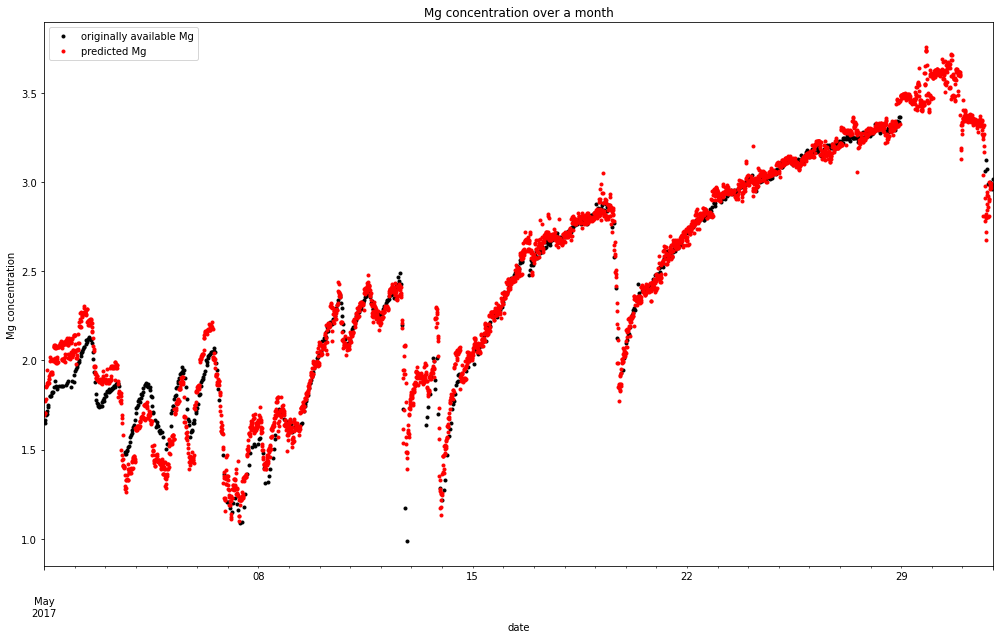

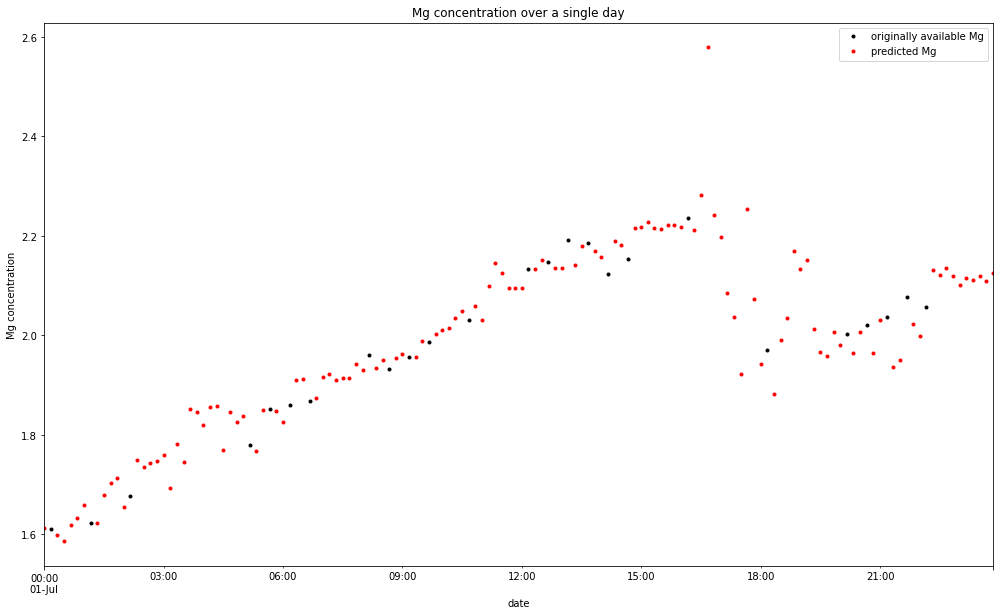

In [66]:
predict('Mg', regr, Mg_related_features, magnesium_and_features, '2017-05',  '2017-05', '2017-07-01', '2017-07-01')

## Chloride

In [67]:
chloride = ion_concentration[ion_concentration['Cl'].notna()].Cl.to_frame()
chloride_and_features = pd.merge(probe_data10min_no_comments, chloride, left_index=True, right_index=True)
chloride_and_features.head(2)

,precipitation,water_temperature,water_electrical_conductivity,flow,turbidity,NO3-Neq,TOCeq,DOCeq,dissolved_oxygen,temperature_DO,conductivity,temperature_EC,pH,ORP,dQ/dt,time_of_day,time_of_year,Cl
date,,,,,,,,,,,,,,,,,,
2017-03-06 18:20:00,0.0,0.255273,206.5,2.503481,1.024896,1.10,0.808211,3.90,9.84,5.5,208.0,4.5,8.00,375.0,0.000000,-0.996195,0.902045,0.559
2017-03-06 19:20:00,0.0,0.230449,204.9,2.524858,0.872739,1.17,0.814248,3.93,9.85,5.5,207.0,4.5,8.01,371.0,0.000171,-0.939693,0.902354,0.563


In [68]:
Cl_related_features = chloride_and_features.columns[0:len(chloride_and_features.columns)-1]
Cl_related_features

Index(['precipitation', 'water_temperature', 'water_electrical_conductivity',
       'flow', 'turbidity', 'NO3-Neq', 'TOCeq', 'DOCeq', 'dissolved_oxygen',
       'temperature_DO', 'conductivity', 'temperature_EC', 'pH', 'ORP',
       'dQ/dt', 'time_of_day', 'time_of_year'],
      dtype='object')

In [69]:
y = chloride_and_features['Cl']
X = chloride_and_features[Cl_related_features]

### Model training and testing

Length of the train dataset: 9060
Length of the test dataset: 3884
The best model is obtained with n_estimators = 1000 and learning rate = 0.25


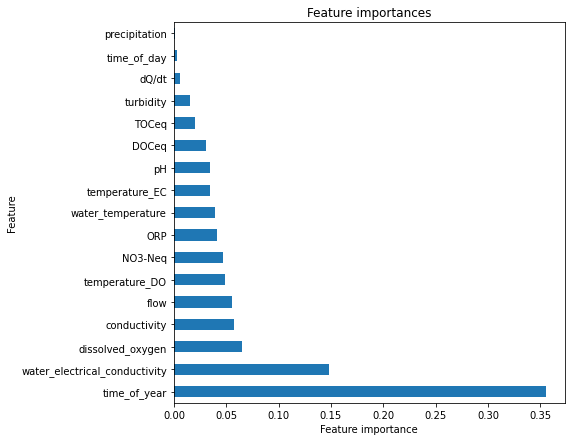

The RMSE for the best model trained on all the training set, over the testing set, is: 0.038
The coefficient of determination for the best model trained on all the training set, over the testing set, is: 0.915
The maximum error is: 0.679 mg/l
The mean absolute error is: 0.019 mg/l
The median absolute error is: 0.010 mg/l


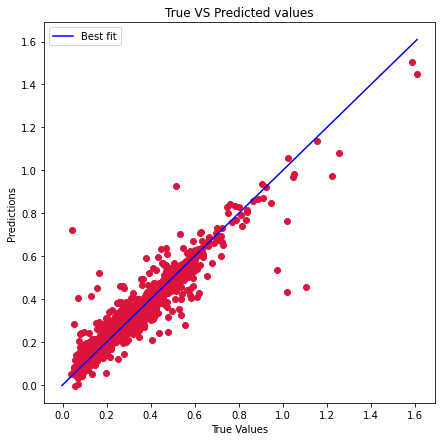

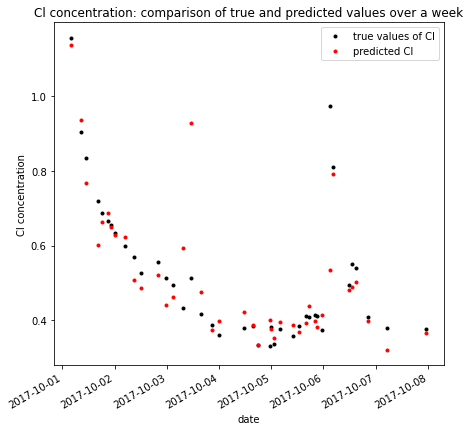

In [70]:
regr = model_train_and_test(chloride_and_features, 'Cl', Cl_related_features)

### Predicting 

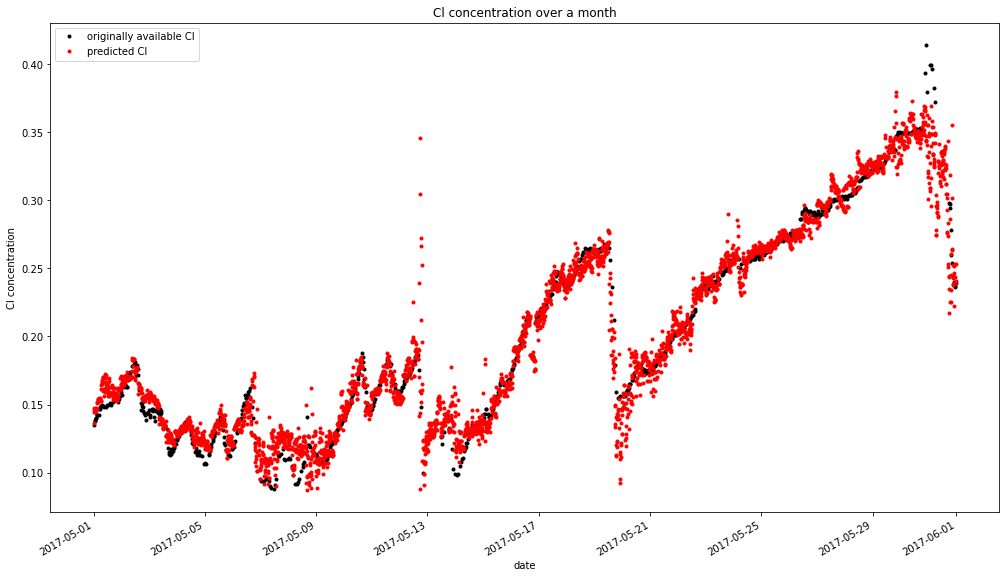

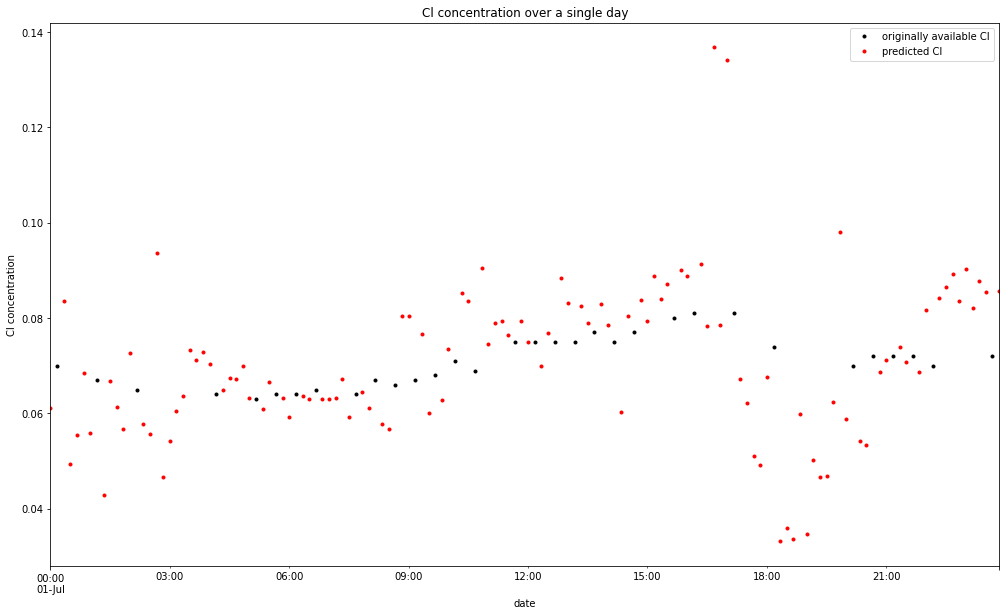

In [71]:
predict('Cl', regr, Cl_related_features, chloride_and_features, '2017-05',  '2017-05', '2017-07-01', '2017-07-01')

## Sodium

In [72]:
sodium = ion_concentration[ion_concentration['Na'].notna()].Na.to_frame()
sodium_and_features = pd.merge(probe_data10min_no_comments, sodium, left_index=True, right_index=True)
sodium_and_features.head(2)

,precipitation,water_temperature,water_electrical_conductivity,flow,turbidity,NO3-Neq,TOCeq,DOCeq,dissolved_oxygen,temperature_DO,conductivity,temperature_EC,pH,ORP,dQ/dt,time_of_day,time_of_year,Na
date,,,,,,,,,,,,,,,,,,
2017-03-06 17:20:00,0.0,0.204120,208.0,2.512760,0.955688,1.11,0.797268,3.61,9.71,5.1,210.0,4.2,8.03,371.0,-0.000771,-0.984808,0.901735,3.232
2017-03-06 18:20:00,0.0,0.255273,206.5,2.503481,1.024896,1.10,0.808211,3.90,9.84,5.5,208.0,4.5,8.00,375.0,0.000000,-0.996195,0.902045,3.268


In [73]:
Na_related_features = sodium_and_features.columns[0:len(sodium_and_features.columns)-1]
Na_related_features

Index(['precipitation', 'water_temperature', 'water_electrical_conductivity',
       'flow', 'turbidity', 'NO3-Neq', 'TOCeq', 'DOCeq', 'dissolved_oxygen',
       'temperature_DO', 'conductivity', 'temperature_EC', 'pH', 'ORP',
       'dQ/dt', 'time_of_day', 'time_of_year'],
      dtype='object')

In [74]:
y = sodium_and_features['Na']
X = sodium_and_features[Na_related_features]

### Model training and testing

Length of the train dataset: 9970
Length of the test dataset: 4274
The best model is obtained with n_estimators = 1000 and learning rate = 0.25


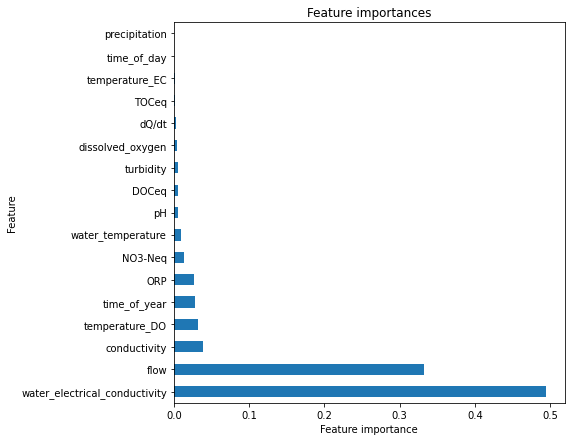

The RMSE for the best model trained on all the training set, over the testing set, is: 0.095
The coefficient of determination for the best model trained on all the training set, over the testing set, is: 0.988
The maximum error is: 1.321 mg/l
The mean absolute error is: 0.062 mg/l
The median absolute error is: 0.042 mg/l


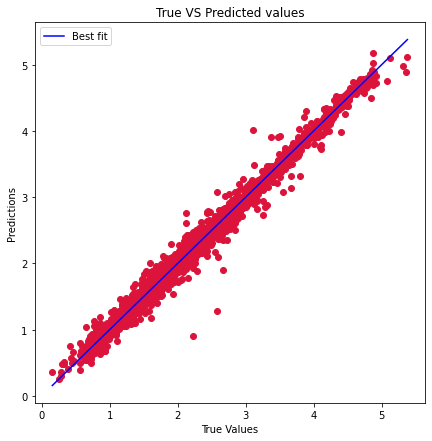

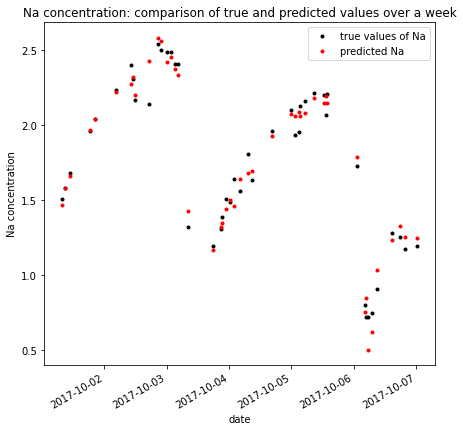

In [75]:
regr = model_train_and_test(sodium_and_features, 'Na', Na_related_features)

### Predicting

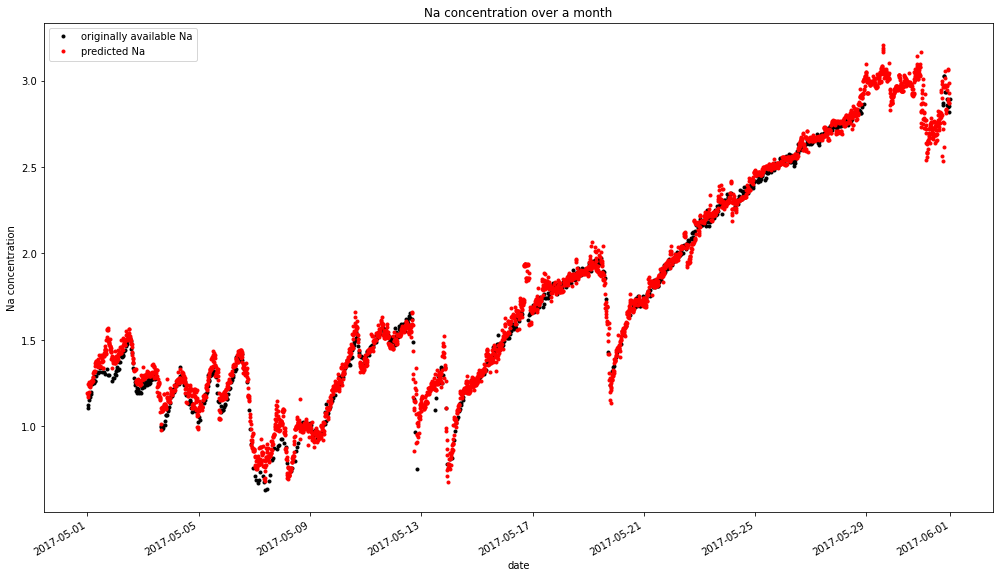

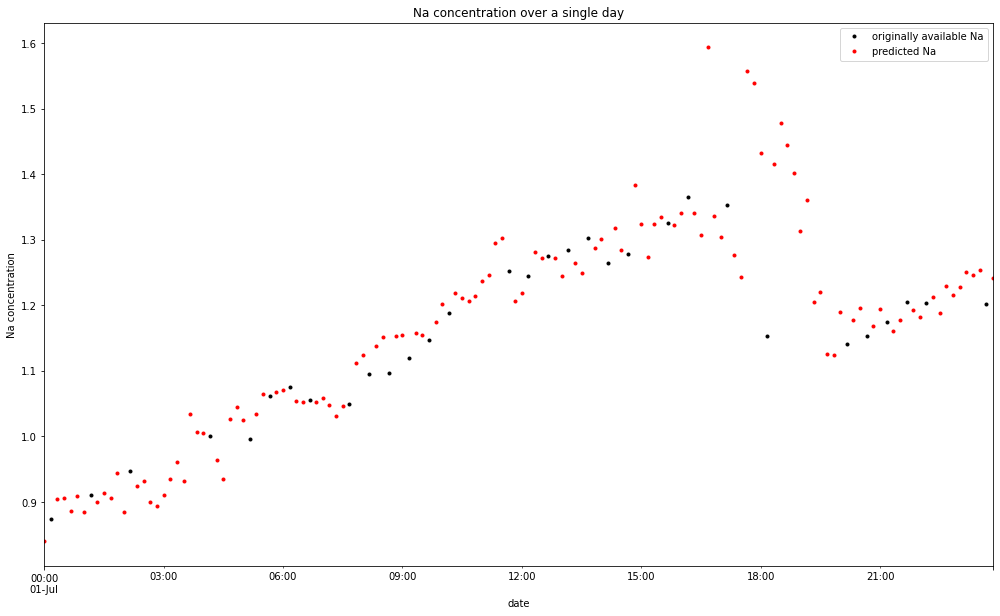

In [76]:
predict('Na', regr, Na_related_features, sodium_and_features, '2017-05',  '2017-05', '2017-07-01', '2017-07-01')

## Potassium

In [77]:
potassium = ion_concentration[ion_concentration['K'].notna()].K.to_frame()
potassium_and_features = pd.merge(probe_data10min_no_comments, potassium, left_index=True, right_index=True)
potassium_and_features.head(2)

,precipitation,water_temperature,water_electrical_conductivity,flow,turbidity,NO3-Neq,TOCeq,DOCeq,dissolved_oxygen,temperature_DO,conductivity,temperature_EC,pH,ORP,dQ/dt,time_of_day,time_of_year,K
date,,,,,,,,,,,,,,,,,,
2017-03-06 18:20:00,0.0,0.255273,206.5,2.503481,1.024896,1.10,0.808211,3.90,9.84,5.5,208.0,4.5,8.00,375.0,0.000000,-0.996195,0.902045,1.112
2017-03-06 21:20:00,0.3,0.204120,205.0,2.406901,0.855519,1.17,0.813581,3.92,9.99,5.4,207.0,4.4,8.02,381.0,-0.001714,-0.642788,0.902971,1.101


In [78]:
K_related_features = potassium_and_features.columns[0:len(potassium_and_features.columns)-1]
K_related_features

Index(['precipitation', 'water_temperature', 'water_electrical_conductivity',
       'flow', 'turbidity', 'NO3-Neq', 'TOCeq', 'DOCeq', 'dissolved_oxygen',
       'temperature_DO', 'conductivity', 'temperature_EC', 'pH', 'ORP',
       'dQ/dt', 'time_of_day', 'time_of_year'],
      dtype='object')

In [79]:
y = potassium_and_features['K']
X = potassium_and_features[K_related_features]

### Model training and testing

Length of the train dataset: 9655
Length of the test dataset: 4138
The best model is obtained with n_estimators = 1000 and learning rate = 0.25


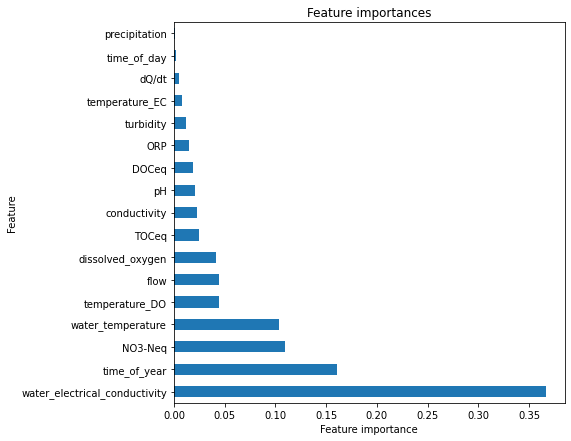

The RMSE for the best model trained on all the training set, over the testing set, is: 0.039
The coefficient of determination for the best model trained on all the training set, over the testing set, is: 0.953
The maximum error is: 0.563 mg/l
The mean absolute error is: 0.024 mg/l
The median absolute error is: 0.015 mg/l


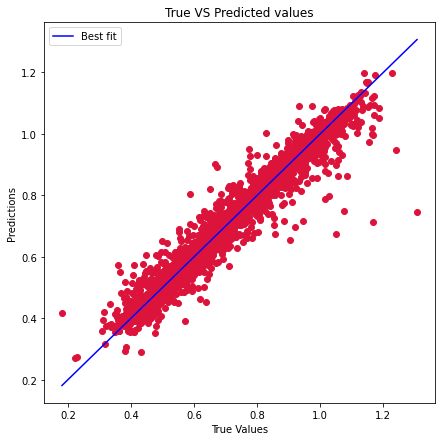

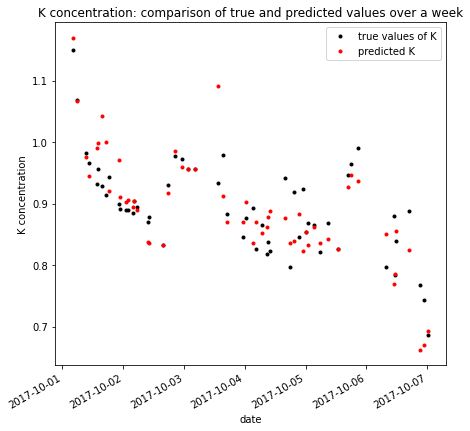

In [80]:
regr = model_train_and_test(potassium_and_features, 'K', K_related_features)

### Predicting

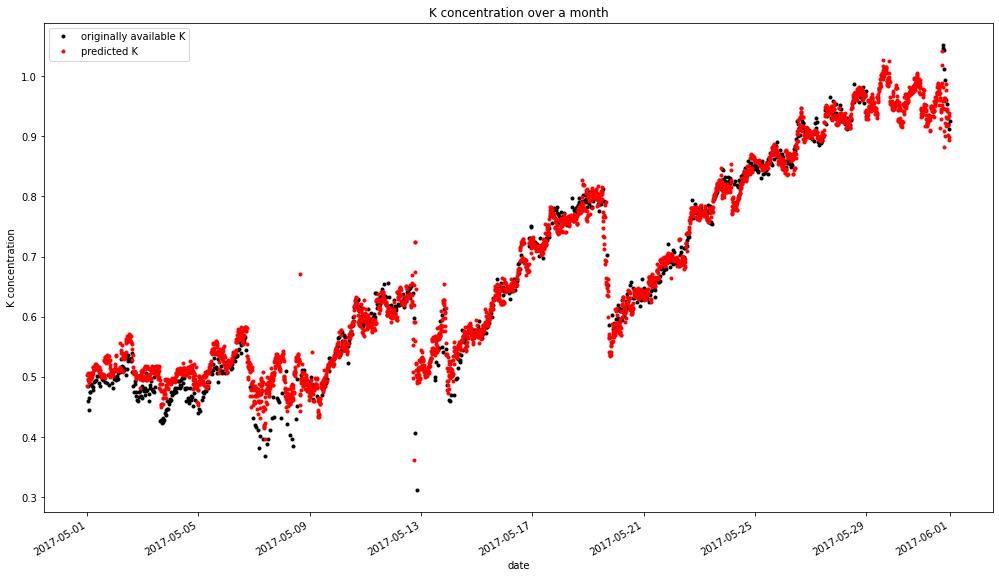

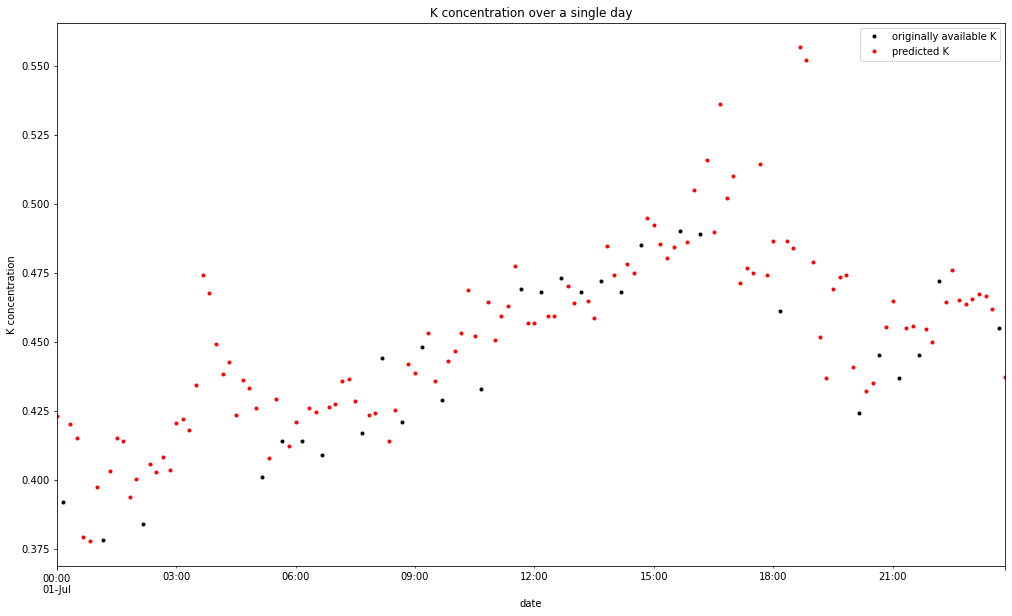

In [81]:
predict('K', regr, K_related_features, potassium_and_features, '2017-05',  '2017-05', '2017-07-01', '2017-07-01')